# Computing distance figures from speeches

This notebooks reads embedded speech vectors and their metadata and computes different distance measures between the speeches

## Imports, methods etc

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel
import os
import pickle
from tqdm import tqdm

### Data locations

Please note raw data folder names **may not** include dots, i.e. folder 'ParliaMint-GB.txt' is not allowed!

In [247]:
__location__ = os.path.abspath("")
feather_path = os.path.join(__location__, '..', 'data', 'gb_commons_embeedings_subset.feather')
rawdata_root = os.path.join(__location__, '..', 'data', 'ParlaMint-GB')


In [248]:
def metadata_to_csv(directory):
    
    df = pd.DataFrame()
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if 'meta' in file:
                file_path = os.path.join(subdir, file)
                df_meta = pd.read_csv(file_path, sep='\t')
                df = pd.concat([df, df_meta])
                
    return df

In [250]:
def speech_to_csv(directory, df):
    ID_to_text = {}

    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if 'meta' not in file and 'ParlaMint' in file:
                filepath = os.path.join(subdir, file)
                try:
                    df_speeches = pd.read_csv(filepath, header=None, names=['ID', 'Speech'], delimiter='\t')
                except:
                    continue
                dict_speeches = pd.Series(df_speeches.Speech.values, index=df_speeches.ID).to_dict()
                ID_to_text.update(dict_speeches)
                
    df['speech'] = df.ID.apply(lambda x: ID_to_text.get(x, None))
    
    return df

In [251]:
def read_feather(path):

    return pd.read_feather(path)

def read_raw(path):

    df = metadata_to_csv(str(path))
    df = speech_to_csv(str(path), df)
    return df

In [252]:
def read_embeddings(path):

    with (open(path, "rb")) as openfile:
        while True:
            try:
                embeddings = pickle.load(openfile)
            except EOFError:
                break

In [280]:
def filter_df(df):

    # check if Date_datetime column exists
    if 'Date_datetime' not in df.columns:
        df['Date_datetime'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df['speech_length'] = df['speech'].apply(lambda x: len(x.split()))
    # compute week
    df['week'] = df['Date_datetime'].apply(lambda x: str(x.year) + '-' + str(x.week))
    df['month'] = df['Date_datetime'].apply(lambda x: str(x.year) + '-' + str(x.month))
    # #filter out speeches with less than 100 words
    df = df[df['speech_length'] > 10]
    #filter out speeches where the speaker is not a mp
    df = df[df['Speaker_MP'] == 'MP']
    df = df[df['Speaker_role'] == 'Regular']
    #reset index
    df = df.reset_index(drop=True)

    return df

In [254]:
def merge_embeds_and_df(df, embeddings):

    merged_df = df.merge(embeddings, left_on='ID', right_on=embeddings.index, how='inner')

    return merged_df

## Read non-embedded data and create DF from a Feather file

In [170]:
#read the feather file
df = pd.read_feather(feather_path)
#filter the dataframe
df = filter_df(df)
df.head()
print(len(df))

608257


## ...or read non-embedded data from raw files

In [281]:
df = read_raw(rawdata_root)
#filter the dataframe
df = filter_df(df)
df.head()
print(len(df))

608257


## Read the embedded vectors

In [282]:
# define pickle path
pklpath = os.path.abspath(os.path.join(__location__, '..', 'data', 'ParlaMint_GB_commons_embeddings_truncated.pkl'))

with (open(pklpath, "rb")) as openfile:
    while True:
        try:
            embeddings = pickle.load(openfile)
        except EOFError:
            break

# make df with embeddings
df_embeddings = pd.DataFrame(index=embeddings.keys())
df_embeddings['embeddings'] = embeddings.values()
df_embeddings.head()

,embeddings
ParlaMint-GB_2017-11-20-commons.u1,"[-0.052915774, -0.06561286, -0.0050254813, 0.0..."
ParlaMint-GB_2017-11-20-commons.u2,"[-0.048129626, 0.3123391, -0.008071972, -0.084..."
ParlaMint-GB_2017-11-20-commons.u3,"[0.127124, 0.031141866, -0.0068759085, 0.01661..."
ParlaMint-GB_2017-11-20-commons.u4,"[0.027221974, 0.08362359, -0.0067807273, 0.003..."
ParlaMint-GB_2017-11-20-commons.u5,"[0.040574398, 0.09211578, -0.0046407003, -0.02..."


## Merge data frames

In [283]:
mergeddf = merge_embeds_and_df(df, df_embeddings)
mergeddf.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,Date_datetime,speech_length,week,month,embeddings
0,ParlaMint-GB_2022-03-14-commons.u1,"Minutes of the House of Commons, Daily Session...",2022-03-14,Lower house,58,NaN,NaN,2022-03-14,NaN,War,...,Opposition,"Siddiq, Tulip Rizwana",F,-,1. What steps he is taking to help ensure that...,2022-03-14,19,2022-11,2022-3,"[-0.12859888, 0.074511044, -0.006566014, -0.04..."
1,ParlaMint-GB_2022-03-14-commons.u2,"Minutes of the House of Commons, Daily Session...",2022-03-14,Lower house,58,NaN,NaN,2022-03-14,NaN,War,...,NaN,"Zahawi, Nadhim",M,-,It is wonderful that the hon. Lady has returne...,2022-03-14,61,2022-11,2022-3,"[-0.121110134, 0.01263293, -0.008577596, 0.048..."
2,ParlaMint-GB_2022-03-14-commons.u3,"Minutes of the House of Commons, Daily Session...",2022-03-14,Lower house,58,NaN,NaN,2022-03-14,NaN,War,...,Opposition,"Siddiq, Tulip Rizwana",F,-,"The Labour Government built more than 3,600 Su...",2022-03-14,131,2022-11,2022-3,"[-0.2661872, 0.04491798, -0.0050289677, -0.042..."
3,ParlaMint-GB_2022-03-14-commons.u4,"Minutes of the House of Commons, Daily Session...",2022-03-14,Lower house,58,NaN,NaN,2022-03-14,NaN,War,...,NaN,"Zahawi, Nadhim",M,-,What the hon. Lady omitted to say was that Sur...,2022-03-14,97,2022-11,2022-3,"[-0.15984681, -0.031378657, -0.004415231, 0.05..."
4,ParlaMint-GB_2022-03-14-commons.u5,"Minutes of the House of Commons, Daily Session...",2022-03-14,Lower house,58,NaN,NaN,2022-03-14,NaN,War,...,NaN,"Aldous, Peter James Guy",M,-,2. What progress he has made in rolling out in...,2022-03-14,12,2022-11,2022-3,"[-0.017177947, 0.17290851, -0.00057190715, -0...."


## Compute monthly values

In [284]:
#list distinct weeks in df
months = mergeddf['month'].unique()
dfm = pd.DataFrame(columns=['week', 'cos_sim', 'party_distance'])

for m in tqdm(months):
    #filter df to only include speeches from week w
    df_m = mergeddf[mergeddf['month'] == m]
    #filter vectors to only include speeches from week w
    vectors_m = df_m['embeddings'].values
    vectors_m = np.array([np.array(x) for x in vectors_m])
    #calculate mean vector for date d
    mean_vector_m = np.mean(vectors_m, axis=0)
    #calculate cosine similarity between mean vector and all vectors for week w
    cos_sim_m = cosine_similarity(vectors_m, mean_vector_m.reshape(1, -1))
    #list distinct parties in df_w
    parties = df_m['Speaker_party'].unique()
    #calculate mean vector for each party
    mean_vectors = []
    for p in parties:
        #filter vectors to only include vectors where speaker party is p
        vectors_p = df_m[df_m['Speaker_party'] == p]['embeddings'].values
        vectors_p = np.array([np.array(x) for x in vectors_p])
        #calculate mean vector for party p
        mean_vector_p = np.mean(vectors_p, axis=0)
        mean_vectors.append(mean_vector_p)
    #compute party weights
    party_weights = np.array([len(df_m[df_m['Speaker_party'] == p]) for p in parties])
    party_weights = party_weights / np.sum(party_weights)
    #compute party vector distances to mean vector
    party_distances = np.array([np.linalg.norm(mean_vector_p - mean_vector_m) for mean_vector_p in mean_vectors])
    party_distances = party_distances @ party_weights.T
    prtd = np.sum(party_distances)
    #compute mean cosine similarity for week w
    cos_sim = np.mean(cos_sim_m)
    r = pd.DataFrame([[m, cos_sim, prtd]], columns=['month', 'cos_sim', 'party_distance'])
    #add cosine similarity to dfw
    dfm = pd.concat([dfm, r])

100%|██████████| 83/83 [00:07<00:00, 10.98it/s]


      week   cos_sim  party_distance  party_distance_norm
0  2015-10  0.585215        1.209126             0.447231
1  2015-11  0.590963        1.067095             0.394697
2  2015-12  0.588640        0.956216             0.353685
3  2015-13  0.599911        1.978301             0.731734
4   2015-2  0.584181        1.894286             0.700659


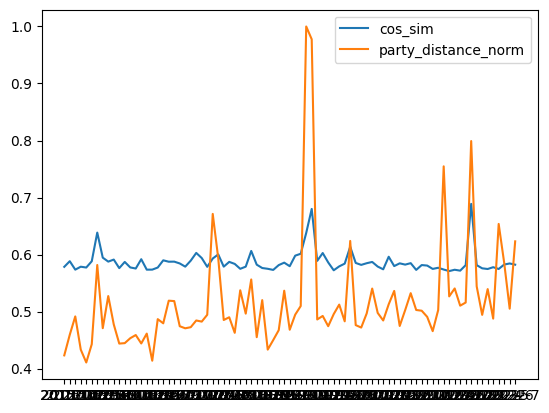

In [285]:
monthly = dfm.sort_values(by=['month']).reset_index(drop=True)
print(weekly.head())
monthly['party_distance_norm'] = monthly['party_distance'] / np.max(monthly['party_distance'])
plt.plot(monthly['month'], monthly['cos_sim'])
plt.plot(monthly['month'], monthly['party_distance_norm'])
plt.legend(['cos_sim', 'party_distance_norm'])
plt.show()
